In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!git clone https://github.com/realcrane/iPLAN-Interactive-and-Procedural-Layout-Planning

import os
print("Directory di lavoro corrente:", os.getcwd())
roomType_directory = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/'
os.chdir(roomType_directory)
print("Nuova directory di lavoro:", os.getcwd())

Mounted at /content/drive/
Cloning into 'iPLAN-Interactive-and-Procedural-Layout-Planning'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 301 (delta 96), reused 106 (delta 46), pack-reused 91
Receiving objects: 100% (301/301), 12.98 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Directory di lavoro corrente: /content
Nuova directory di lavoro: /content/iPLAN-Interactive-and-Procedural-Layout-Planning


In [2]:
import numpy as np
import torch
from synth.floorplan.roomtype_fp import FloorPlan
from room_type import models
import scipy.io as sio

In [3]:
def getList(path):
  mat_list = os.listdir(path)
  mat_list.sort()
  temp_list = []
  for name in mat_list[:]: #Correzione
      mat_path = os.path.join(path, name)
      data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)['data']
      if type(data.rTypes) is not np.ndarray or len(data.rTypes) == 0:
          temp_list.append(name)

  return temp_list

#ROOM TYPE


In [4]:
max_room_per_type = [1, 2, 1, 2, 1, 1, 1, 3, 1, 3, 1, 1, 1]
max_room_num = np.sum(np.array(max_room_per_type))
noise_dim = 32
load_cvae_path = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_type/roomtype_cvae_150.pth"

# step1: configure model
print('Building model...')
cvae = models.cvae(
    modul_name='roomtype',
    model_name='cvae',
    input_dim=max_room_num,
    hidden_dim1=128,
    hidden_dim2=64,
    z_dim=noise_dim
)
print(cvae)

cvae.load_model(load_cvae_path)
cvae.cuda()

# step2: data

data_root = "/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data/test"
floorplans = getList(data_root)

Input = []
Output = []
# step3: testing
for i in range(len(floorplans)):
  fp_name = floorplans[i]
  fp_path = os.path.join(data_root, fp_name)
  fp = FloorPlan(fp_path)

  # if given room types
  # fp.rTypes = fp.gt_rTypes
  # fp.rBoxes = np.array([])
  # fp.rCenters= np.array([])
  # data = fp.to_dict()
  # sio.savemat(fp_path, {'data': data})

  input_img = fp.init_input_img(fp.exterior_boundary)
  Input.append(input_img)
  input_img = torch.FloatTensor(input_img).unsqueeze(0).unsqueeze(0).cuda()
  input_img = fp.normalize(input_img)

  with torch.no_grad():
    emb = cvae.embed(input_img)
    z = torch.randn(input_img.size(0), 32).cuda()
    o_z = torch.cat([z, emb], 1)
    sample = cvae.decoder(o_z).cuda()
    sample = sample.view(-1, 19)
    fp.update_rTypes(sample.squeeze().cpu().numpy(), max_room_per_type)
    fp.rBoxes = np.array([])
    fp.rCenters = np.array([])
    data = fp.to_dict()
    Output.append(data)
    #sio.savemat(fp_path, {'data': data})

Building model...
CVAE(
  (fc1): Linear(in_features=83, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc31): Linear(in_features=64, out_features=32, bias=True)
  (fc32): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=96, out_features=96, bias=True)
  (fc5): Linear(in_features=96, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=19, bias=True)
  (relu): ReLU()
  (embed): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

## Risultati

In [5]:
for dictionary in Output:
  for key, value in dictionary.items():
    if key == "rTypes": print(value)

[0 1 2 3 7 9]
[0 1 2 3 7 7]


## SALVATAGGIO DATI

In [27]:
sio.savemat("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/RoomType/0.mat", {"data" : Output[0]})
sio.savemat("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/RoomType/1.mat",{"data" : Output[1]})

#LOCATING ROOM

In [6]:
def check_rcenters(center, rCenters):
    flag = True
    center = np.array(center)
    for i in range(len(rCenters)):
        temp = np.array(rCenters[i])
        dist = np.linalg.norm(center - temp)
        if dist < 9:
            flag = False
            return flag
    return flag

In [7]:
def find_center(predict, r_t, mask_size=4):
    index_point = []
    index = np.where(predict == r_t.cpu().numpy())
    for ind in range(index[0].shape[0]):
        index_point.append((index[0][ind], index[1][ind]))

    num_point = 0
    if len(index_point) > 0:
        min_h = np.min(index[0])
        min_w = np.min(index[1])
        max_h = np.max(index[0])
        max_w = np.max(index[1])

        if max_h - min_h + 1 <= 2 * mask_size and max_w - min_w + 1 <= 2 * mask_size:
            predict_h = (min_h + max_h) // 2
            predict_w = (min_w + max_w) // 2
            num_point = len(index_point)
        else:
            predict_h, predict_w = index_point[0]
            for point in index_point:
                new_num_point = 0
                for other_point in index_point:
                    if abs(other_point[0] - point[0]) <= mask_size and abs(
                            other_point[1] - point[1]) <= mask_size:
                        new_num_point += 1
                if new_num_point > num_point:
                    predict_h, predict_w = point
                    num_point = new_num_point
    if num_point > 0:
        return np.array([predict_h, predict_w])
    else:
        return np.array([0, 0])

In [8]:
def get_rcenters(fp, location_model, location_connect, location_embedding, mask_size=4):
    pred_rCenters = []
    pred_rTypes = []

    living_node = fp.living_node
    h, w = living_node['centroid']
    pred_rCenters.append(np.array([int(h), int(w)]))
    pred_rTypes.append(0)

    input_location = fp.get_composite_location(num_extra_channels=0)
    continue_rTypes = fp.continue_rTypes.squeeze()
    input_location = input_location.unsqueeze(0).cuda()

    room_num = continue_rTypes.shape[0]

    iter = 0
    flag = True
    while room_num > 0:
        update_id = np.zeros(room_num, dtype=bool)
        iter = iter + 1

        np.random.shuffle(continue_rTypes)
        with torch.no_grad():
            for n in range(room_num):
                score_model = location_model(input_location)
                r_t = torch.LongTensor(continue_rTypes[n:n + 1]).cuda()
                one_hot_label = torch.nn.functional.one_hot(r_t, num_classes=13)
                score_embedding = location_embedding(one_hot_label.float())
                score_temp = torch.cat([score_model, score_embedding], 1)
                score_connect = location_connect(score_temp)

                score_softmax = torch.softmax(score_connect, dim=1)
                output = score_softmax.cpu().numpy()
                predict = np.argmax(output, axis=1)[0]

                center = find_center(predict, r_t)
                h, w = center

                if h == 0 or w == 0 or input_location[0, 0, h, w] == 0:
                    continue

                flag = check_rcenters(center, pred_rCenters)

                if flag:
                    pred_rCenters.append(np.array([h, w]))
                    pred_rTypes.append(r_t.cpu().numpy().reshape(1)[0])
                    update_id[n] = True
                    min_h = max(h - mask_size, 0)
                    max_h = min(h + mask_size, 128 - 1)
                    min_w = max(w - mask_size, 0)
                    max_w = min(w + mask_size, 128 - 1)
                    input_location[0, r_t + 4, min_h:max_h + 1, min_w:max_w + 1] = 1.0
                    input_location[0, 3, :, :] = input_location[0, 4:, :, :].sum(0)

                    iter = 0

        continue_rTypes = continue_rTypes[~update_id]
        room_num = continue_rTypes.shape[0]

        if iter > 5:
            if room_num == 0:  # 0: all room centers are located, 1: one room missing, 2: two room missing
                flag = True
            else:
                flag = False
            break

    return pred_rCenters, pred_rTypes, flag

In [38]:
def getListLR(path):
  mat_list = os.listdir(path)
  mat_list.sort()
  temp_list = []
  for name in mat_list[:]:
      mat_path = os.path.join(path, name)
      data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)["data"]
      if len(data.rCenters) == 0:
          temp_list.append(name)
  return temp_list

In [9]:
from synth.floorplan.roomlocation_fp import FloorPlan
from room_location.Living import models as living
from room_location.Location import models as location

In [10]:
path_model_roomLocation_resnet = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/resnet18-5c106cde.pth"

path_model_roomLocation_location_resnet = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/location_resnet18_100.pth"
path_model_roomLocation_location_up = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/location_up1_100.pth"
path_model_roomLocation_location_embed = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/location_embed_100.pth"

path_model_roomLocation_living_fci = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/living_fc1_300.pth"
path_model_roomLocation_living_resnet = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/living_resnet18_300.pth"

In [11]:
# step1: configure model
print('Building model...')
living_model = living.model(
    module_name="living",
    model_name="resnet18_fc1",
    input_channel=3,
    output_channel=2,
    pretrained=False,
)
living_connect = living.connect(
    module_name="living",
    model_name="resnet18_fc1",
    input_channel=512,
    output_channel=2,
    reshape=True
)

load_living_model_path = path_model_roomLocation_living_resnet
load_living_connect_path = path_model_roomLocation_living_fci
living_model.load_model(load_living_model_path)
living_connect.load_model(load_living_connect_path)
living_model.cuda()
living_connect.cuda()

location_model = location.model(
    module_name='location',
    model_name='resnet18_up1',
    input_channel=13 + 4,
    output_channel=13 + 3,
    pretrained=True,
    pretrained_path= path_model_roomLocation_resnet
)

location_connect = location.connect(
    module_name='location',
    model_name='resnet18_up1',
    input_channel=512,
    output_channel=13 + 3,
    reshape=False
)
location_embedding = location.embedding(
    module_name='location',
    model_name='resnet18_up1',
    input_channel=13,
    output_channel=256,
    reshape=False
)
epoch = 100
load_location_model_path = path_model_roomLocation_location_resnet
load_location_connect_path = path_model_roomLocation_location_up
load_location_embedding_path = path_model_roomLocation_location_embed

location_model.load_model(load_location_model_path)
location_connect.load_model(load_location_connect_path)
location_embedding.load_model(load_location_embedding_path)
location_model.cuda()
location_connect.cuda()
location_embedding.cuda()

living_model.eval()
living_connect.eval()
location_model.eval()
location_connect.eval()
location_embedding.eval()


Building model...
load the pretrained model...


Embedding(
  (fc): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [39]:
# step2: data
data_root = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/RoomType"
floorplans = getListLR(data_root)
print('The length of testing data is {}'.format(len(floorplans)))

The length of testing data is 2


In [40]:
# step3: testing
print('Starting to Testing...')
total = 0
Data = []
for i in range(len(Output)):
  fp_name = floorplans[i]
  print(fp_name)
  fp_path = os.path.join(data_root, fp_name)
  print(fp_path)
  fp = FloorPlan(fp_path)

  input_living = fp.get_composite_living()
  input_living = input_living.unsqueeze(0).cuda()

  with torch.no_grad():
    score_model = living_model(input_living)
    score_connect_living = living_connect(score_model)
    living_center = torch.round(score_connect_living)
    living_center = living_center.cpu().squeeze().numpy()

  node = {}
  node['category'] = int(0)
  x = living_center[0]
  y = living_center[1]
  node['centroid'] = (int(x), int(y))
  fp.add_room(node)
  fp.living_node = node

  iteration = 0
  # the maximum sampling for room location
  while iteration < 50:
    iteration = iteration + 1
    pred_rCenters, pred_rTypes, flag = get_rcenters(fp, location_model, location_connect, location_embedding)
    if flag:
      fp.update_rCenters(pred_rCenters, pred_rTypes)
      data = fp.to_dict()
      Data.append(data)
      sio.savemat(fp_path, {'data': data})
      total = total + 1
      print('{}/{}, has processd {} '.format(i + 1, total, data['name']))
      break

print(f'{total} layouts')



Starting to Testing...
0.mat
/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/RoomType/0.mat
1/1, has processd 0 
1.mat
/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/RoomType/1.mat
2/2, has processd 1 
2 layouts


## Risultati


In [42]:
for data in Data:
  for key, value in data.items():
    if key == "rCenters": print(value)

[[ 58  71]
 [ 93  48]
 [ 33  65]
 [ 72  43]
 [ 53  47]
 [108  78]]
[[64 69]
 [79 33]
 [40 69]
 [36 52]
 [81 59]
 [39 32]]


## SALVATAGGIO DATI

In [43]:
sio.savemat("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/LocationRoom/0.mat", {"data" : Data[0]})
sio.savemat("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/LocationRoom/1.mat",{"data" : Data[1]})

# PARTITIONING ROOM

In [55]:
def fine_turning(pred_rBoxes, boundary, living_mask, criterion, opt):
  lr = opt.lr
  pred_rBoxes = torch.autograd.Variable(pred_rBoxes, requires_grad=True)
  loss = criterion(pred_rBoxes, boundary, living_mask, opt)
  loss.backward()
  grad = pred_rBoxes.grad
  pred_rBoxes = pred_rBoxes - lr * grad
  return pred_rBoxes

def get_ratio(layout):
  spare_area = (layout == 16).sum()
  inside_area = (layout < 13).sum() + spare_area
  ratio = spare_area / inside_area
  return ratio

def obtain_living(layout, boundary):
  living_mask = layout.clone()
  living_mask[living_mask < 16] = 0
  min_y, min_x = np.min(boundary[:, :2], 0)
  max_y, max_x = np.max(boundary[:, :2], 0)
  for h in range(int(min_x) - 5, int(max_x) + 5):
    for w in range(int(min_y) - 5, int(max_y) + 5):
      if living_mask[h, w] == 0 and living_mask[h + 1, w] == 16 and living_mask[h + 2, w] == 0:
        living_mask[h + 1, w] = 0
      elif living_mask[h, w] == 0 and living_mask[h + 1, w] == 16 and living_mask[h + 2, w] == 16 and living_mask[
        h + 3, w] == 0:
        living_mask[h + 1, w] = 0
        living_mask[h + 2, w] = 0
      elif living_mask[h, w] == 0 and living_mask[h + 1, w] == 16 and living_mask[h + 2, w] == 16 and living_mask[
        h + 3, w] == 16 and living_mask[h + 4, w] == 0:
        living_mask[h + 1, w] = 0
        living_mask[h + 2, w] = 0
        living_mask[h + 3, w] = 0

      if living_mask[h, w] == 0 and living_mask[h, w + 1] == 16 and living_mask[h, w + 2] == 0:
        living_mask[h, w + 1] = 0
      elif living_mask[h, w] == 0 and living_mask[h, w + 1] == 16 and living_mask[h, w + 2] == 16 and living_mask[
        h, w + 3] == 0:
        living_mask[h, w + 1] = 0
        living_mask[h, w + 2] = 0
      elif living_mask[h, w] == 0 and living_mask[h, w + 1] == 16 and living_mask[h, w + 2] == 16 and living_mask[
        h, w + 3] == 16 and living_mask[h, w + 4] == 0:
        living_mask[h, w + 1] = 0
        living_mask[h, w + 2] = 0
        living_mask[h, w + 3] = 0
  layout[living_mask==16]=0
  index = torch.where(living_mask)
  min_x, max_x = torch.min(index[0]),torch.max(index[0])
  min_y, max_y = torch.min(index[1]), torch.max(index[1])
  box = torch.stack([min_y, min_x, max_y, max_x]) / 127
  return box, layout, living_mask/16

def get_image(img, rBoxes, rTypes, inside, living_mask=None):
  if not living_mask==None:
    img[living_mask==1]=0
  for r_i in range(len(rTypes)):
    r_box = rBoxes[r_i, :] * 127
    r_box = r_box.long()
    r_type = rTypes[r_i]
    mask = torch.zeros(inside.size())
    mask[r_box[1]:r_box[3] + 1, r_box[0]:r_box[2] + 1] = 1
    mask = mask * inside
    img = img * (1 - mask) + mask * r_type
  return img

In [58]:
def getListRP(path):
    mat_list = os.listdir(path)
    mat_list.sort()
    temp_list = []
    for name in mat_list[:]:
        mat_path = os.path.join(path, name)
        data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)['data']
        if len(data.rBoxes) == 0 and len(data.rCenters) !=0:
            temp_list.append(name)
    return temp_list

In [44]:
import sys
sys.path.append('/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition')
sys.path.append('/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/models')

In [45]:
from synth.floorplan.roompartition_fp import FloorPlan
from room_partition.utils import colorize_mask
from room_partition import models
import argparse

In [46]:
import shutil


cartella_origine = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/utils'
cartella_destinazione = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/models'

shutil.move(cartella_origine, cartella_destinazione)


'/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/models/utils'

In [47]:
from room_partition.models.loss_layer import LossFun

In [48]:
class AttrDict(dict):
    """Classe wrapper per consentire l'accesso attributivo agli elementi del dizionario."""

    def __getattr__(self, name):
        return self[name]

    def __setattr__(self, name, value):
        self[name] = value

In [49]:
opt = AttrDict({
    'load_netG_path': '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_partition/G_net_210.pth',
    'max_iter': 200,
    'gpu_ids': [0],
    'lr': 10,
    'coverage': 1,
    'inside': 0.5,
    'mutex': 0,
    'root': '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data'
})

In [50]:
from models.floorplan_rnn_test import FloorPlanRNN

In [51]:
# step1: configure model
print('Building model...')
fp_rnn = FloorPlanRNN(opt)
fp_rnn.load_networks(opt)
criterion = LossFun(device=fp_rnn.device)

Building model...
load the pretrained Mask generation model


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [60]:
# step2: data
print('Building dataset...')
data_root = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/LocationRoom"
floorplans = getListRP(data_root)
print('The length of testing data is {}'.format(len(floorplans)))

Building dataset...
The length of testing data is 2


In [61]:
def getMath(path, i ):
  mat_list = os.listdir(path)
  mat_list.sort()
  temp_list = []
  for name in mat_list[:]:
    mat_path = os.path.join(path, name)
    data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)['data']
    data.rTypes = np.array([1])
    if name == "0.mat":
      center = []
      center.append([58,71])
      data.rCenters = np.array(center)
      if i == 0: return data
    else:
      center = []
      center.append([64,69])
      data.rCenters = np.array(center)
      if i ==1: return data

In [68]:
def get_input(mat_path):
  data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)['data']

  img = fp.init_input_img(fp.exterior_boundary)
  h, w = img.shape
  inside = np.zeros((h, h))
  inside[img == 16] = 1
  inside[img < 13] = 1
  inside_mask = torch.from_numpy(inside)
  img = torch.from_numpy(img)

  #print(data.rTypes)
  ind = data.rTypes == 0
  # print(data.rTypes == 0)
  ind = np.array(ind)
  # print(ind)
  # print(data.rCenters)
  continue_rTypes = data.rTypes[~ind]
  # print(continue_rTypes)
  continue_rCenters = data.rCenters[~ind]
  # print(continue_rCenters)

  rCenters=[]
  for i in range(len(continue_rTypes)):
    r_c = np.zeros((128, 128))
    c_x, c_y = continue_rCenters[i,:]
    r_c[c_x - 1:c_x + 2, c_y - 1:c_y + 2] = 1
    rCenters.append(r_c)

  rCenters = np.stack(rCenters, 0)
  rCenters = torch.FloatTensor(rCenters)

  return img, rCenters, torch.from_numpy(continue_rTypes), inside_mask, data.Boundary

In [71]:
# step3: testing
Data = []
Image = []
print('Starting to Testing...')
for i in range(len(floorplans)):
  fp_name = floorplans[i]
  fp_path = os.path.join(data_root, fp_name)
  fp = FloorPlan(fp_path)
  img, rCenters, rTypes, inside, boundary = get_input(fp_path)
  fp_rnn.evaluate(img, rCenters, rTypes, inside)

  boundary = boundary[:, [1, 0, 2, 3]]
  pred_rBoxes = fp_rnn.pred_rBoxes
  pred_rBoxes = pred_rBoxes[:, [1, 0, 3, 2]]

  layout = get_image(img, pred_rBoxes, rTypes, inside)
  living_box, layout, living_mask = obtain_living(layout, boundary)

  criterion.get_initial_mutex(pred_rBoxes, boundary)

  iter = 0
  while get_ratio(layout) > 0.0005 and iter < opt.max_iter:
      iter = iter + 1
      pred_rBoxes = fine_turning(pred_rBoxes, boundary, living_mask, criterion, opt)
      layout = get_image(img, pred_rBoxes, rTypes, inside, living_mask)
  image = colorize_mask(layout.numpy())
  Image.append(image)
  print(fp.name)

  fp.update_rBoxes(pred_rBoxes.detach().cpu().numpy())
  data = fp.to_dict()
  Data.append(data)

Starting to Testing...
0
1


## Risultati

In [72]:
Data

[{'name': '0',
  'gt_rTypes': array([0, 1, 2, 3, 7, 9]),
  'gt_rBoxes': array([[ 14,  55, 101,  92],
         [ 80,  36, 110,  62],
         [ 26,  57,  41,  72],
         [ 65,  36,  78,  53],
         [ 43,  36,  63,  62],
         [103,  64, 114,  92]]),
  'Boundary': array([[ 19,  82,   1,   1],
         [ 27,  82,   1,   1],
         [ 43,  82,   0,   0],
         [ 43,  92,   1,   0],
         [114,  92,   2,   0],
         [114,  64,   3,   0],
         [110,  64,   2,   0],
         [110,  36,   3,   0],
         [ 43,  36,   0,   0],
         [ 43,  57,   3,   0],
         [ 26,  57,   0,   0],
         [ 26,  74,   3,   0],
         [ 14,  74,   0,   0],
         [ 14,  82,   1,   0]]),
  'rTypes': array([0, 1, 2, 3, 7, 9]),
  'rBoxes': array([[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]),
  'rCenters': array([[ 58,  71],
         [ 93,  48],
         [ 33,  65],
         [ 72,  43],
         [ 53,  47],
         [1

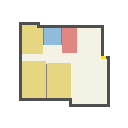

In [73]:
Image[1]

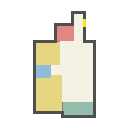

In [75]:
Image[0]

## SALVATAGGIO DATI

In [78]:
sio.savemat("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/RoomPartition/0.mat", {"data" : Data[0]})
sio.savemat("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/RoomPartition/1.mat", {"data" : Data[1]})

In [81]:
Image[0].save("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/Output/img0.png")
Image[1].save("/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Risultati/Output/img1.png")